In [3]:
%matplotlib inline


Preprocessing Tutorial
======================

Before spike sorting, you may need to preproccess your signals in order to improve the spike sorting performance.
You can do that in SpikeInterface using the :code:`toolkit.preprocessing` submodule.




In [2]:
import numpy as np
import matplotlib.pylab as plt
import scipy.signal

import spikeinterface.extractors as se
import spikeinterface.toolkit as st

First, let's create a toy example:



In [4]:
recording, sorting = se.example_datasets.toy_example(num_channels=4, duration=10, seed=0)

Apply filters
-----------------
 
Now apply a bandpass filter and a notch filter (separately) to the
recording extractor. Filters are also RecordingExtractor objects.



In [13]:
recording_bp = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
recording_notch = st.preprocessing.notch_filter(recording, freq=1000, q=10)

In [14]:
recording_bp2 = st.preprocessing.bandpass_filter(recording, type='butter',freq_min=300, freq_max=6000)

In [36]:
b, a = scipy.signal.butter(3,np.array([300,6000]),btype='bandpass', fs=30000.0)
recording_bp3 = scipy.signal.filtfilt(b,a,recording.get_traces()[0])

array([  0.55245179,   3.51503479, -13.22619284, ...,  10.62603275,
        -0.12241234,  -0.80132453])

Now let's plot the power spectrum of non-filtered, bandpass filtered,
and notch filtered recordings.



In [38]:
f_raw, p_raw = scipy.signal.welch(recording.get_traces(), fs=recording.get_sampling_frequency())
f_bp, p_bp = scipy.signal.welch(recording_bp.get_traces(), fs=recording.get_sampling_frequency())
f_bp2, p_bp2 = scipy.signal.welch(recording_bp2.get_traces(), fs=recording.get_sampling_frequency())
f_bp3, p_bp3 = scipy.signal.welch(recording_bp3, fs=recording.get_sampling_frequency())

f_notch, p_notch = scipy.signal.welch(recording_notch.get_traces(), fs=recording.get_sampling_frequency())



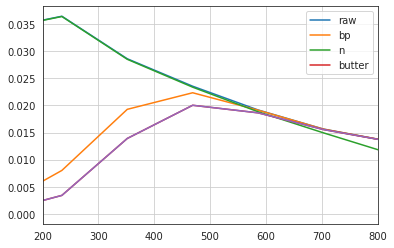

In [39]:
fig, ax = plt.subplots()
ax.plot(f_raw, p_raw[0], f_bp, p_bp[0], f_notch, p_notch[0], f_bp2, p_bp2[0], f_bp3, p_bp3)
ax.grid()
ax.set_xlim([200,800])
ax.legend(['raw','bp','n','butter'])

In [17]:
recording.get_sampling_frequency()

30000.0

Compute LFP and MUA
--------------------
 
Local field potentials (LFP) are low frequency components of the
extracellular recordings. Multi-unit activity (MUA) are rectified and
low-pass filtered recordings showing the diffuse spiking activity.
 
In :code:`spiketoolkit`, LFP and MUA can be extracted combining the
:code:`bandpass_filter`, :code:`rectify` and :code:`resample` functions. In this
example LFP and MUA are resampled at 1000 Hz.



In [ ]:
recording_lfp = st.preprocessing.bandpass_filter(recording, freq_min=1, freq_max=300)
recording_lfp = st.preprocessing.resample(recording_lfp, 1000)
recording_mua = st.preprocessing.resample(st.preprocessing.rectify(recording), 1000)

In [42]:
??st.preprocessing.RectifyRecording

Init signature: st.preprocessing.RectifyRecording(recording)
Docstring:     
A class that contains functions for extracting important information
from recorded extracellular data. It is an abstract class so all
functions with the @abstractmethod tag must be implemented for the
initialization to work.
Source:        
class RectifyRecording(RecordingExtractor):

    preprocessor_name = 'Rectify'
    installed = True  # check at class level if installed or not
    preprocessor_gui_params = []
    installation_mesg = ""  # err

    def __init__(self, recording):
        self._recording = recording
        RecordingExtractor.__init__(self)
        self.copy_channel_properties(recording)

    def get_sampling_frequency(self):
        return self._recording.get_sampling_frequency()

    def get_num_frames(self):
        return self._recording.get_num_frames()

    def get_traces(self, channel_ids=None, start_frame=None, end_frame=None):
        if start_frame is None:
            start_frame 

The toy example data are only contain high frequency components, but
 these lines of code will work on experimental data



Change reference
-------------------

In many cases, before spike sorting, it is wise to re-reference the
signals to reduce the common-mode noise from the recordings.

To re-reference in :code:`spiketoolkit` you can use the :code:`common_reference`
function. Both common average reference (CAR) and common median
reference (CMR) can be applied. Moreover, the average/median can be
computed on different groups. Single channels can also be used as
reference.



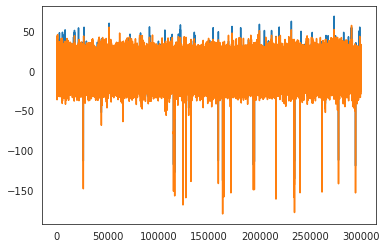

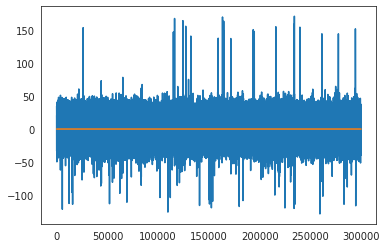

In [43]:
recording_car = st.preprocessing.common_reference(recording, reference='average')
recording_cmr = st.preprocessing.common_reference(recording, reference='median')
recording_single = st.preprocessing.common_reference(recording, reference='single', ref_channels=[0])
recording_single_groups = st.preprocessing.common_reference(recording, reference='single',
                                                            groups=[[0, 1], [2, 3]], ref_channels=[0, 2])


fig1, ax1 = plt.subplots()
ax1.plot(recording_car.get_traces()[0])
ax1.plot(recording_cmr.get_traces()[0])

fig2, ax2 = plt.subplots()
ax2.plot(recording_single_groups.get_traces()[1])  # not zero
ax2.plot(recording_single_groups.get_traces()[0])

Remove bad channels
----------------------
 
In to remove noisy channels from the analysis, the
:code:`remove_bad_channels` function can be used.



In [44]:
recording_remove_bad = st.preprocessing.remove_bad_channels(recording, bad_channel_ids=[0])

print(recording_remove_bad.get_channel_ids())

[1, 2, 3]


As expected, channel 0 is removed. Bad channels removal can also be done
automatically. In this case, the channels with a standard deviation
exceeding :code:`bad_threshold` times the median standard deviation are
removed. The standard deviations are computed on the traces with length
:code:`seconds` from the middle of the recordings.



In [45]:
recording_remove_bad_auto = st.preprocessing.remove_bad_channels(recording, bad_channel_ids=None, bad_threshold=2,
                                                                 seconds=2)

print(recording_remove_bad_auto.get_channel_ids())

[0, 1, 2, 3]


With these simulated recordings, there are no noisy channel.



Remove stimulation artifacts
 -------------------------------
  
 In some applications, electrodes are used to electrically stimulate the
 tissue, generating a large artifact. In :code:`spiketoolkit`, the artifact
 can be zeroed-out using the :code:`remove_artifact` function.



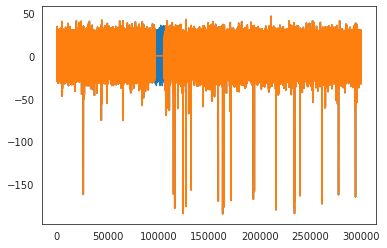

In [46]:
# create dummy stimulation triggers
stimulation_trigger_frames = np.array([100000, 500000, 700000])

# large ms_before and s_after are used for plotting only
recording_rmartifact = st.preprocessing.remove_artifacts(recording,
                                                         triggers=stimulation_trigger_frames,
                                                         ms_before=100, ms_after=200)

fig3, ax3 = plt.subplots()
ax3.plot(recording.get_traces()[0])
ax3.plot(recording_rmartifact.get_traces()[0])

You can list the available preprocessors with:



In [47]:
print(st.preprocessing.preprocessers_full_list)

[<class 'spiketoolkit.preprocessing.bandpass_filter.BandpassFilterRecording'>, <class 'spiketoolkit.preprocessing.notch_filter.NotchFilterRecording'>, <class 'spiketoolkit.preprocessing.whiten.WhitenRecording'>, <class 'spiketoolkit.preprocessing.common_reference.CommonReferenceRecording'>, <class 'spiketoolkit.preprocessing.resample.ResampleRecording'>, <class 'spiketoolkit.preprocessing.rectify.RectifyRecording'>, <class 'spiketoolkit.preprocessing.remove_artifacts.RemoveArtifactsRecording'>, <class 'spiketoolkit.preprocessing.remove_bad_channels.RemoveBadChannelsRecording'>, <class 'spiketoolkit.preprocessing.transform_traces.TransformTracesRecording'>, <class 'spiketoolkit.preprocessing.normalize_by_quantile.NormalizeByQuantileRecording'>, <class 'spiketoolkit.preprocessing.clip_traces.ClipTracesRecording'>, <class 'spiketoolkit.preprocessing.blank_saturation.BlankSaturationRecording'>]
